In [1]:
import pandas as pd
df = pd.read_csv('Epileptic Seizure Recognition.csv')
df.head()

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


Load Dataset and Preprocess Data \ Create test and train data loaders

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader

# Load the dataset
df = pd.read_csv('Epileptic Seizure Recognition.csv')

# Clean the dataset
df.drop(columns=['Unnamed', 'Unnamed: 0'], errors='ignore', inplace=True)
df['y'] = df['y'].apply(lambda x: 1 if x == 1 else 0)

# Split into features and labels
X = df.drop(columns=['y']).values
y = df['y'].values

# Normalize the features
scaler = StandardScaler() # Acts as a function of x - x.mean() / x.std()
X_scaled = scaler.fit_transform(X) # Perfrom fit and transform

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


Define the network

In [3]:
import torch.nn as nn

class SeizureNet(nn.Module):
    def __init__(self):
        super(SeizureNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(178, 64),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()  # For binary classification, may want to change to a softmax function
        )

    def forward(self, x):
        return self.net(x)

#gpu integration does not work right now
#gpu = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
#model = SeizureNet().to(gpu)
model = SeizureNet()
#shows first layer matrix
#print(model.net[0].weight) 

Train the model

In [4]:
import torch.optim as optim

train_losses = []
val_losses = []

criterion = nn.BCELoss() # Binary Cross-Entropy loss between predicted and actual labels
optimizer = optim.Adam(model.parameters(), lr=0.001) #optimizer

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad() # Set all gradients back to zero
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward() # Calculates gradient of the function
        optimizer.step() # Performs the parameter update according to the current gradient, stored in grad
        running_loss += loss.detach().item()
    train_losses.append(running_loss / len(train_loader))
# Validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.detach().item()

    val_losses.append(val_loss / len(test_loader))
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

Epoch 1/20, Train Loss: 0.3036, Val Loss: 0.1031
Epoch 2/20, Train Loss: 0.1377, Val Loss: 0.0865
Epoch 3/20, Train Loss: 0.1183, Val Loss: 0.0798
Epoch 4/20, Train Loss: 0.0993, Val Loss: 0.0695
Epoch 5/20, Train Loss: 0.0839, Val Loss: 0.0654
Epoch 6/20, Train Loss: 0.0867, Val Loss: 0.0695
Epoch 7/20, Train Loss: 0.0783, Val Loss: 0.0631
Epoch 8/20, Train Loss: 0.0732, Val Loss: 0.0620
Epoch 9/20, Train Loss: 0.0729, Val Loss: 0.0624
Epoch 10/20, Train Loss: 0.0668, Val Loss: 0.0647
Epoch 11/20, Train Loss: 0.0645, Val Loss: 0.0598
Epoch 12/20, Train Loss: 0.0602, Val Loss: 0.0588
Epoch 13/20, Train Loss: 0.0632, Val Loss: 0.0601
Epoch 14/20, Train Loss: 0.0608, Val Loss: 0.0554
Epoch 15/20, Train Loss: 0.0588, Val Loss: 0.0609
Epoch 16/20, Train Loss: 0.0546, Val Loss: 0.0558
Epoch 17/20, Train Loss: 0.0578, Val Loss: 0.0578
Epoch 18/20, Train Loss: 0.0511, Val Loss: 0.0525
Epoch 19/20, Train Loss: 0.0496, Val Loss: 0.0619
Epoch 20/20, Train Loss: 0.0551, Val Loss: 0.0517


Evaluate the model and include ROC curve/performance measures

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9886    0.9907    0.9897      1835
         1.0     0.9631    0.9548    0.9590       465

    accuracy                         0.9835      2300
   macro avg     0.9759    0.9728    0.9743      2300
weighted avg     0.9834    0.9835    0.9835      2300



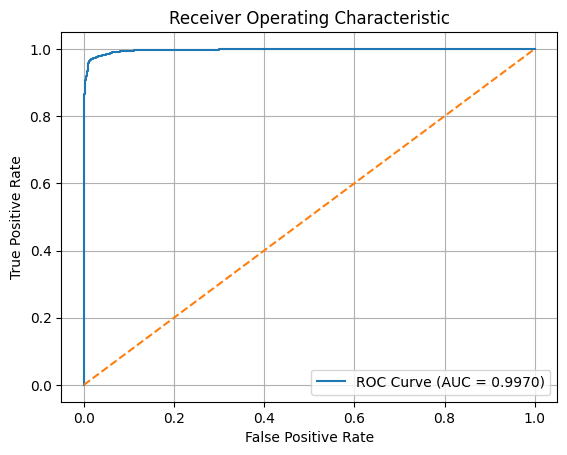

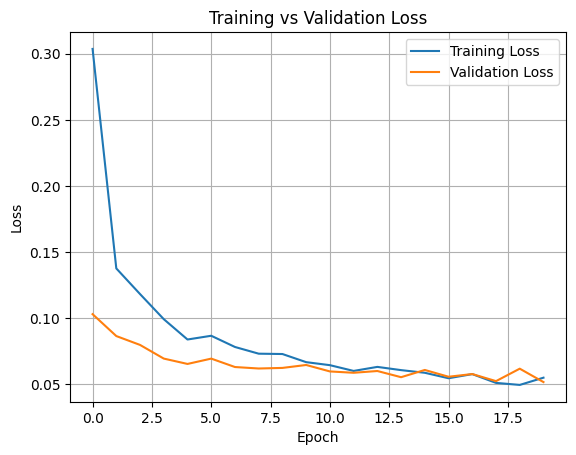

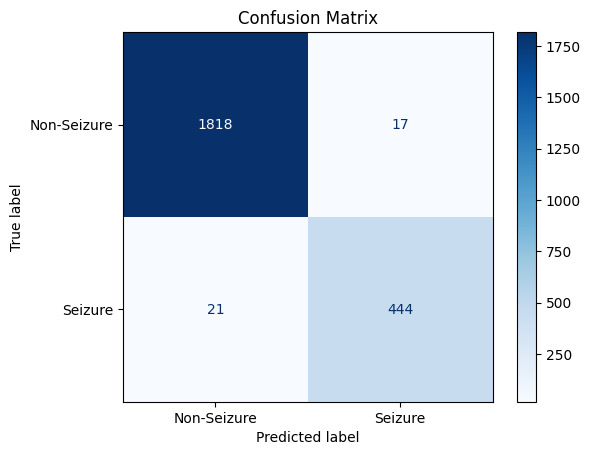

In [5]:
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()
all_preds = []
all_probs = []
all_labels = []
#correct = 0
#total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        probs = outputs.numpy().flatten()
        predicted = (outputs > 0.5).float().numpy().flatten()
        all_preds.extend(predicted)
        all_probs.extend(probs)
        all_labels.extend(labels.numpy().flatten())
        #total += labels.size(0)
        #correct += (predicted == labels).sum().item()

#print(f"Test Accuracy: {100 * correct / total:.2f}%")
# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.grid(True)
plt.show()

# Training vs Validation Loss Plot
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Seizure", "Seizure"])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()